# AirNow.gov
> This notebook fetches the current weather and air quality conditions from a ZIP code. 

---

#### Import Python tools and Jupyter config

In [1]:
import requests
import pandas as pd
import jupyter_black
import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point

In [2]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

In [3]:
today = pd.Timestamp.today().strftime("%Y-%m-%d")

---

## Fetch

#### Headers for requests

In [4]:
headers = {
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36",
}

#### What's the ZIP code?

In [5]:
zipcode = "90066"

#### Fetch the longitude and latitude from the ZIP code

In [6]:
params = {
    "SingleLine": zipcode,
    "f": "json",
    "outSR": '{"wkid":4326}',
    "outFields": "PlaceName,Type,City,Region,Country,Addr_type",
    "category": "City,Region,Postal",
    "countryCode": "US",
    "maxLocations": "6",
}

response = requests.get(
    "https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/findAddressCandidates",
    params=params,
    headers=headers,
)

In [7]:
longitude = response.json()["candidates"][0]["location"]["x"]

In [8]:
latitude = response.json()["candidates"][0]["location"]["y"]

#### Fetch air quality readings using the derived lon/lat

In [9]:
data = {
    "latitude": latitude,
    "longitude": longitude,
    "maxDistance": "50",
}

response = requests.post(
    "https://airnowgovapi.com/reportingarea/get", headers=headers, data=data
)

#### Read response into a dataframe

In [10]:
src = pd.DataFrame(response.json())

#### Process dates

In [11]:
src["validDate"] = pd.to_datetime(src["validDate"], format="%m/%d/%y").dt.strftime(
    "%Y-%m-%d"
)
src["issueDate"] = pd.to_datetime(src["issueDate"], format="%m/%d/%y").dt.strftime(
    "%Y-%m-%d"
)

#### Current conditions

In [12]:
src.query('dataType == "O"')

,issueDate,validDate,recordSequence,timezone,time,dataType,isPrimary,reportingArea,stateCode,latitude,longitude,parameter,aqi,category,isActionDay,discussion,reportingAgency
5,2024-08-15,2024-08-15,0,PDT,9:00,O,True,SW Coastal LA,CA,33.9541,-118.4302,PM2.5,37,Good,False,,South Coast AQMD
6,2024-08-15,2024-08-15,0,PDT,9:00,O,False,SW Coastal LA,CA,33.9541,-118.4302,PM10,20,Good,False,,South Coast AQMD
7,2024-08-15,2024-08-15,0,PDT,9:00,O,False,SW Coastal LA,CA,33.9541,-118.4302,OZONE,16,Good,False,,South Coast AQMD


#### Forecast for current date

In [13]:
src.query('dataType == "F" and validDate == validDate.max()')

,issueDate,validDate,recordSequence,timezone,time,dataType,isPrimary,reportingArea,stateCode,latitude,longitude,parameter,aqi,category,isActionDay,discussion,reportingAgency
8,2024-08-14,2024-08-15,1,PDT,,F,True,SW Coastal LA,CA,33.9541,-118.4302,PM2.5,58,Moderate,False,,South Coast AQMD
9,2024-08-14,2024-08-15,1,PDT,,F,False,SW Coastal LA,CA,33.9541,-118.4302,PM10,27,Good,False,,South Coast AQMD
10,2024-08-14,2024-08-15,1,PDT,,F,False,SW Coastal LA,CA,33.9541,-118.4302,OZONE,34,Good,False,,South Coast AQMD
11,2024-08-14,2024-08-15,1,PDT,,F,False,SW Coastal LA,CA,33.9541,-118.4302,CO,2,Good,False,,South Coast AQMD
12,2024-08-14,2024-08-15,1,PDT,,F,False,SW Coastal LA,CA,33.9541,-118.4302,NO2,20,Good,False,,South Coast AQMD


---

## Weather

#### Fetch current weather conditions using same location params

In [14]:
response = requests.post(
    "https://airnowgovapi.com/weather/get", headers=headers, data=data
)

In [15]:
weather_now = pd.DataFrame(response.json(), index=[0])
weather_now

,temperature,category,description,visibility,windSpeed,windDirection,temperatureFeelsLike,temperatureMinimum,temperatureMaximum,pressure,humidity,cloudiness
0,76.0,fair_day,clear sky,10000.0,3.44,0.0,76.33,72.25,81.14,1013.0,71.0,0.0


---

## Geography

#### Fetch regional air quality map data

In [16]:
response = requests.get(
    "https://services.arcgis.com/cJ9YHowT8TU7DUyn/arcgis/rest/services/AirNowLatestContoursCombined/FeatureServer/0/query?returnGeometry=true&where=1%3D1&outSr=4326&outFields=*&inSr=4326&geometry=%7B%22xmin%22%3A-123.75%2C%22ymin%22%3A31.952162238024975%2C%22xmax%22%3A-112.5%2C%22ymax%22%3A40.979898069620155%2C%22spatialReference%22%3A%7B%22wkid%22%3A4326%7D%7D&geometryType=esriGeometryEnvelope&spatialRel=esriSpatialRelIntersects&geometryPrecision=5&maxAllowableOffset=0.016151329139610388&f=geojson",
    headers=headers,
)
geojson_data = response.json()

#### Into a GeoDataFrame

In [17]:
gdf = gpd.GeoDataFrame.from_features(
    geojson_data["features"], crs=geojson_data["crs"]["properties"]["name"]
)

#### Clip air quality map to local boundaries

In [18]:
lacity = gpd.read_file(
    "https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson"
).to_crs("EPSG:4326")

In [19]:
lacounty = (
    gpd.read_file(
        "https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/15/query?outFields=*&where=1%3D1&f=geojson"
    )
    .to_crs("EPSG:4326")
    .query("OBJECTID == 4")
)

In [20]:
gdf_clipped = gdf.clip(lacounty)

#### Assign categories for air quality codes

In [21]:
codes = {
    "1": "Good",
    "2": "Moderate",
    "3": "Unhealthy for Sensitive Groups",
    "4": "Unhealthy",
    "5": "Very Unhealthy",
    "6": "Hazardous",
}

In [22]:
gdf_clipped["gridcode"] = gdf_clipped["gridcode"].astype(str).map(codes)

#### Colors for air quality categories

In [23]:
category_colors = {
    "Good": "#00e400",
    "Moderate": "#ffff00",
    "Unhealthy for Sensitive Groups": "#ff7e00",
    "Unhealthy": "#ff0000",
    "Very Unhealthy": "#8f3f97",
    "Hazardous": "#7e0023",
}

#### Map the categorical colors to the GeoDataFrame

In [24]:
gdf_clipped["color"] = gdf_clipped["gridcode"].map(category_colors)

#### Create a GeoDataFrame for my location from previous lon/lat

In [25]:
my_location = gpd.GeoDataFrame(
    [["My location", Point(longitude, latitude)]],
    columns=["name", "geometry"],
    crs=gdf.crs,
)

#### Plot the map with my location and LA city boundary for reference

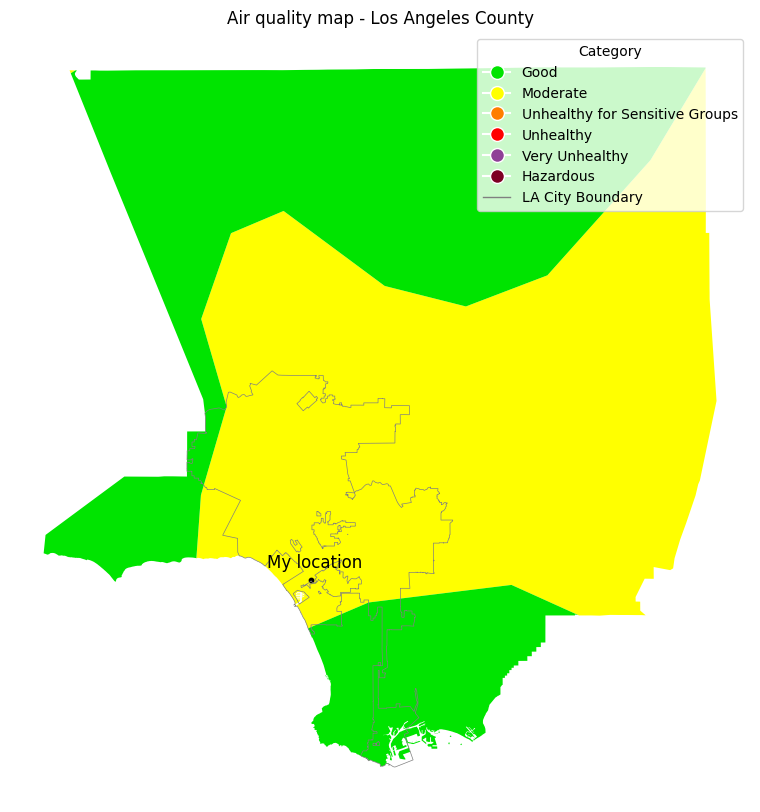

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the air quality map for LA County
gdf_clipped.plot(ax=ax, color=gdf_clipped["color"], legend=True)

# Plot the LA city boundary
lacity.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, label="LA City Boundary")

# Plot the location marker
my_location.plot(ax=ax, marker="o", color="black", markersize=10, label="My location")

# Label the point with an offset
for x, y, label in zip(
    my_location.geometry.x, my_location.geometry.y, my_location["name"]
):
    ax.text(x + 0.1, y + 0.02, label, fontsize=12, ha="right")

# Create a custom legend for air quality
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color,
        markersize=10,
        label=label,
    )
    for label, color in category_colors.items()
]

# Add the LA city boundary to the legend
handles.append(
    plt.Line2D([0], [0], color="gray", linewidth=1, label="LA City Boundary")
)

plt.legend(
    handles=handles,
    title="Category",
)

# Remove x and y axis coordinates and border
ax.set_axis_off()

# Show the plot
plt.title("Air quality map - Los Angeles County")
plt.show()